# Описание задачи

В наличии пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Описание столбцов в дата-сете:

* `id` - уникальный идентификатор скважины
* `f0`, `f1`, `f2` - "анонимные" признаки каждой скважины
* `product` - объем запасов в скважине (тысяч баррелей). Целевой признак

# Загрузка, предобработка и подготовка данных

## Загрузка и предобработка данных

In [1]:
# вызываем необходимые библиотеки и расширения
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# зачитываем данные
geo_data_0 = pd.read_csv("/datasets/geo_data_0.csv")
geo_data_1 = pd.read_csv("/datasets/geo_data_1.csv")
geo_data_2 = pd.read_csv("/datasets/geo_data_2.csv")

In [3]:
# посмотрим на размеры дата сета
for ds in [geo_data_0, geo_data_1, geo_data_2]:
    print(ds.shape)
    print("Количество полных дубликатов в данных:", ds.duplicated().sum())
    print()

(100000, 5)
Количество полных дубликатов в данных: 0

(100000, 5)
Количество полных дубликатов в данных: 0

(100000, 5)
Количество полных дубликатов в данных: 0



In [4]:
# посмотрим на размеры дата сета и одновременно посчитаем количество полных дубликатов (при наличии)
for ds in [geo_data_0, geo_data_1, geo_data_2]:
    print(ds.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memor

In [5]:
# проверим все ли идентификаторы в датасете уникальны
for ds in [geo_data_0, geo_data_1, geo_data_2]:
    print("Количество уникальных идентификаторов скважин:", len(ds["id"].unique()))
    print()

Количество уникальных идентификаторов скважин: 99990

Количество уникальных идентификаторов скважин: 99996

Количество уникальных идентификаторов скважин: 99996



In [6]:
# посмотрим на строки, содержащие дубликаты идентификаторов

geo_data_0.loc[
    geo_data_0["id"].isin(list(geo_data_0[geo_data_0["id"].duplicated()]["id"]))
].sort_values(by="id")

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


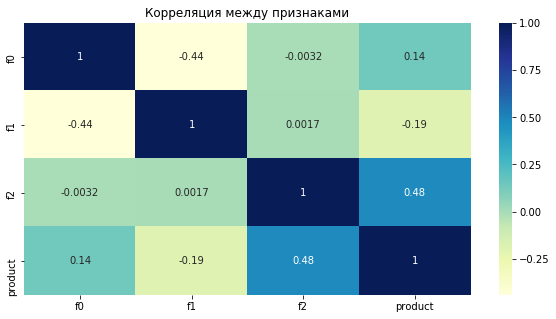

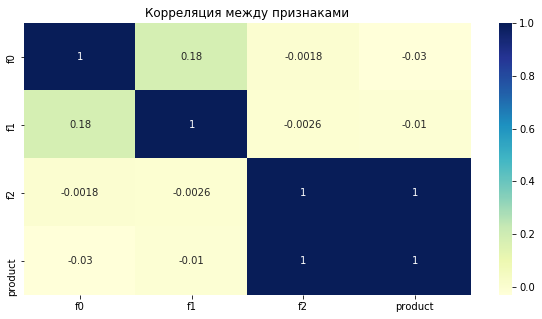

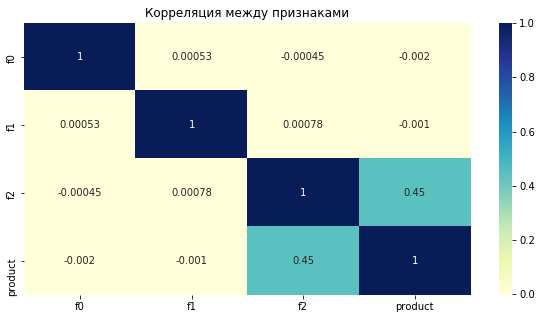

In [7]:
# взглянем на линейные зависимости между признаками в каждом дата-сете

for df in [geo_data_0, geo_data_1, geo_data_2]:
    plt.figure(figsize=[10, 5])
    plt.title("Корреляция между признаками")
    dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
    plt.show()

Промежуточные выводы:

1. Ни в одном из дата-сетов нет пропусков
2. Ни один из дата-сетов не имеет полных дубликтов
3. Столбец `id` несмотря на свое название содержит дублированные значения. Строки с идентичными идентификаторами скважин содержат отличающиеся параметры. Вероятно то какая-то ошибка измерений или получения данных. Так как мы не располагаем возможностью обратиться за уточнением, такие строки можно убрать из всех датасетов, так как максимальная доля записей с дублированными идентификаторами - 0.2%
4. Датасет по региону 2 вызывает вопросы, так как наблюдается очень сильная прямая линейная зависимость между целевым признаком и `f2` (стремится к 1)

In [8]:
# убираем строки с дублированными идентификаторами из дата-сета

geo_data_0 = geo_data_0[
    ~geo_data_0["id"].isin(list(geo_data_0[geo_data_0["id"].duplicated()]["id"]))
].reset_index(drop=True)

geo_data_1 = geo_data_1[
    ~geo_data_1["id"].isin(list(geo_data_1[geo_data_1["id"].duplicated()]["id"]))
].reset_index(drop=True)

geo_data_2 = geo_data_2[
    ~geo_data_2["id"].isin(list(geo_data_2[geo_data_2["id"].duplicated()]["id"]))
].reset_index(drop=True)

## Подготовка данных для обучения

In [9]:
# делим дата-сеты на зависимую и независимые переменные

features_geo_0 = geo_data_0.drop(["id", "product"], axis=1)
target_geo_0 = geo_data_0["product"]

features_geo_1 = geo_data_1.drop(["id", "product"], axis=1)
target_geo_1 = geo_data_1["product"]

features_geo_2 = geo_data_2.drop(["id", "product"], axis=1)
target_geo_2 = geo_data_2["product"]

In [10]:
# данные каждого региона разделим на обучающую и валидационную выборки

train_features_0, valid_features_0, train_target_0, valid_target_0 = train_test_split(
    features_geo_0, target_geo_0, train_size=0.75, random_state=12345
)

train_features_1, valid_features_1, train_target_1, valid_target_1 = train_test_split(
    features_geo_1, target_geo_1, train_size=0.75, random_state=12345
)

train_features_2, valid_features_2, train_target_2, valid_target_2 = train_test_split(
    features_geo_2, target_geo_2, train_size=0.75, random_state=12345
)

In [11]:
# вероятно потребуется стандартизация числовых признаков, поэтому еще раз взглянем на данные

train_features_0

,f0,f1,f2
86197,0.245635,0.128953,2.753394
50770,0.463011,0.891989,3.742645
84497,0.340691,-0.148729,4.693089
43375,-0.291562,1.111994,1.345046
69525,-0.453448,0.885378,6.621671
...,...,...,...
4094,-1.131123,0.053078,-1.589662
85412,1.008319,0.439898,3.961555
2177,1.083401,0.128404,2.425737
77285,2.186453,0.041494,5.414335


In [12]:
# стандартизируем числовые признаки, анализ которых будет делать алгоритм

scaler = StandardScaler()

train_features_0 = scaler.fit_transform(train_features_0)
valid_features_0 = scaler.transform(valid_features_0)

train_features_1 = scaler.fit_transform(train_features_1)
valid_features_1 = scaler.transform(valid_features_1)

train_features_2 = scaler.fit_transform(train_features_2)
valid_features_2 = scaler.transform(valid_features_2)

# Обучение и проверка модели

## Регион 1

In [13]:
# создаем переменную куда кладем алгоритм линейной регрессии
model_0 = LinearRegression()

In [14]:
# обучаем модель
model_0.fit(train_features_0, train_target_0)
predictions_valid_0 = model_0.predict(valid_features_0)

In [15]:
result = mean_squared_error(y_true=valid_target_0, y_pred=predictions_valid_0) ** 0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)
print()
print("Средний запас предсказанного сырья (тыс. баррелей):", predictions_valid_0.mean())

RMSE модели линейной регрессии на валидационной выборке: 37.716904960382735

Средний запас предсказанного сырья (тыс. баррелей): 92.42384109947358


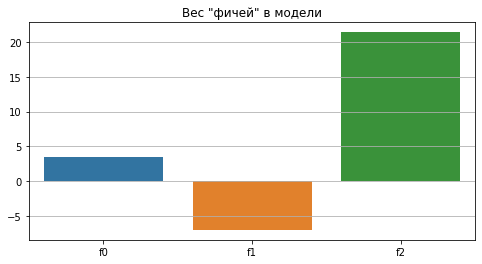

In [16]:
plt.figure(figsize=(8, 4))
plt.title('Вес "фичей" в модели')
plt.grid()
sns.barplot(y=model_0.coef_, x=["f0", "f1", "f2"])
plt.show()

## Регион 2

In [17]:
# создаем переменную куда кладем алгоритм линейной регрессии
model_1 = LinearRegression()

In [18]:
# обучаем модель
model_1.fit(train_features_1, train_target_1)
predictions_valid_1 = model_1.predict(valid_features_1)

In [19]:
result = mean_squared_error(y_true=valid_target_1, y_pred=predictions_valid_1) ** 0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)
print()
print("Средний запас предсказанного сырья (тыс. баррелей):", predictions_valid_1.mean())

RMSE модели линейной регрессии на валидационной выборке: 0.8914901390348529

Средний запас предсказанного сырья (тыс. баррелей): 68.98311857983121


In [20]:
result = mean_squared_error(y_true=valid_target_1, y_pred=predictions_valid_1) ** 0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)
print()
print("Средний запас предсказанного сырья (тыс. баррелей):", predictions_valid_1.mean())

RMSE модели линейной регрессии на валидационной выборке: 0.8914901390348529

Средний запас предсказанного сырья (тыс. баррелей): 68.98311857983121


## Регион 3

In [21]:
# создаем переменную куда кладем алгоритм линейной регрессии
model_2 = LinearRegression()

In [22]:
# обучаем модель
model_2.fit(train_features_2, train_target_2)
predictions_valid_2 = model_2.predict(valid_features_2)

In [23]:
result = mean_squared_error(y_true=valid_target_2, y_pred=predictions_valid_2) ** 0.5
print("RMSE модели линейной регрессии на валидационной выборке:", result)
print()
print("Средний запас предсказанного сырья (тыс. баррелей):", predictions_valid_2.mean())

RMSE модели линейной регрессии на валидационной выборке: 39.975543264382345

Средний запас предсказанного сырья (тыс. баррелей): 95.11622302076478


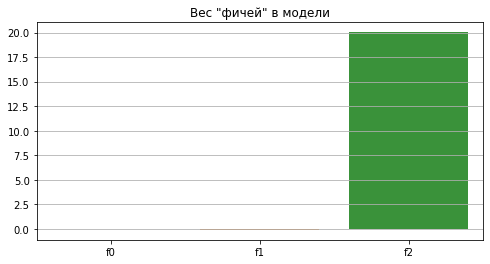

In [24]:
plt.figure(figsize=(8, 4))
plt.title('Вес "фичей" в модели')
plt.grid()
sns.barplot(y=model_2.coef_, x=["f0", "f1", "f2"])
plt.show()

## Промежуточные выводы

Наблюдаем следующее:

1. Средний запас сырья на предсказания по валидационной выборке в регионах 1 и 3 сопоставим - среднеквадратичная ошибка регрессии в регионе 1 немного меньше (37.7 против 40), но и среднее предсказанное количество сырья из 1 скважины в ней меньше
2. Для Региона 2 наблюдаем значительно меньшее количество среднее спрогнозированное количество сырья, но при этом среднеквадратичная ошибка крайне низкая (0.89 против 38 и 40). По всей видимости, такую точность дает прямая линейная связь между признаком `f2` и целевым признаком (ее мы наблюдали в процессе исследования данных)
3. Визуализация значений коэффициентов регрессии показывает, что при прогнозировании целевого признака для регионов 2 и 3 определяющее значение имеет признак `f2`. При этом коэффициент этого признака для региона 2 более чем вдвое превышает коэффициент для региона 3 - это, по всей видимости, результат очень сильной прямой линейной связи между ним и целевым признаком. На мой взгляд, требуется уточнить следующее (похоже, в данных какая-то ошибка):
    * Что это за признак: как он работает? действительно ли он связан с целевым признаком?
    * Как собирались данные?
    * Как данные обрабатывались и готовились к отправке для анализа? 

# Расчет прибыли и рисков

## Подготовка к расчету

In [25]:
# фиксируем значения констант

razvedka = 500
razrabotka = 200
budget = 10000000000
revenue_per_unit = 450000

In [26]:
required_raw_material_volume = (budget / razrabotka) / revenue_per_unit
print(
    "Среднее требуемое количество сырья из 1 скважины для достижения точки безубыточности (тыс. баррелей):",
    round(required_raw_material_volume, 2),
)

Среднее требуемое количество сырья из 1 скважины для достижения точки безубыточности (тыс. баррелей): 111.11


In [27]:
# сравним целевую метрику (количество сырья из 1 скважины для достижения точки безубыточности)

region = 1

for predictions in [predictions_valid_0, predictions_valid_1, predictions_valid_2]:
    mean_raw_material = predictions.mean()
    print(
        f"Дельта между средним прогнозируемым количеством с 1 скважины в регионе и требуемым количеством для региона {region}:",
        round(mean_raw_material - required_raw_material_volume, 2),
    )
    print()
    region += 1

Дельта между средним прогнозируемым количеством с 1 скважины в регионе и требуемым количеством для региона 1: -18.69

Дельта между средним прогнозируемым количеством с 1 скважины в регионе и требуемым количеством для региона 2: -42.13

Дельта между средним прогнозируемым количеством с 1 скважины в регионе и требуемым количеством для региона 3: -15.99



## Расчет прибыли 

### Функция для определения потенциальной прибыли

In [30]:
#формируем последовательности, содержащие реальные запасы сырья для скважин, отобранных моделью 

region_1 = (
    pd.concat(
        [
            pd.Series(valid_target_0).reset_index(drop=True),
            pd.Series(predictions_valid_0),
        ],
        axis=1,
    )
    .sort_values(by=0, ascending=False)
    .head(200)["product"]
)

region_2 = (
    pd.concat(
        [
            pd.Series(valid_target_1).reset_index(drop=True),
            pd.Series(predictions_valid_1),
        ],
        axis=1,
    )
    .sort_values(by=0, ascending=False)
    .head(200)["product"]
)

region_3 = (
    pd.concat(
        [
            pd.Series(valid_target_2).reset_index(drop=True),
            pd.Series(predictions_valid_2),
        ],
        axis=1,
    )
    .sort_values(by=0, ascending=False)
    .head(200)["product"]
)

In [32]:
def profit_calculator(data):
    total_raw_material = data.sum()
    revenue = total_raw_material * revenue_per_unit
    profit = round(int(revenue - budget) / 1000000000, 3)
    return profit

In [54]:
counter = 1
for region in [region_1, region_2, region_3]:
    profit = profit_calculator(region)
    print(f'Прибыль для региона {counter} составит {profit} млрд. рублей')
    counter += 1

Прибыль для региона 1 составит 3.136 млрд. рублей
Прибыль для региона 2 составит 2.415 млрд. рублей
Прибыль для региона 3 составит 2.466 млрд. рублей


### Риски

#### Подготовка функции для бутстрепа

In [33]:
def bootstrap(target, bootstrap_samples=1000):
    state = np.random.RandomState(12345)
    counter = 0
    profit_values = []
    for sample in range(bootstrap_samples):
        subsample = (
            pd.Series(target)
            .sample(n=500, replace=True, random_state=state)
            .sort_values(ascending=False)
        )
        subsample = subsample.head(200)
        profit = profit_calculator(subsample)
        profit_values.append(profit)
    return pd.Series(profit_values)

#### Регион 1

In [34]:
%%time

region_1_profits = bootstrap(predictions_valid_0)

CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.72 s


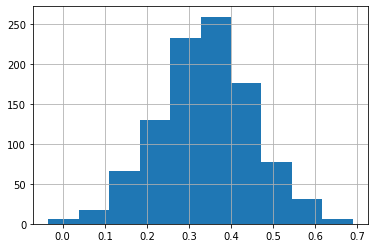

In [35]:
region_1_profits.hist()

In [36]:
lower = region_1_profits.quantile(0.025)
upper = region_1_profits.quantile(0.975)
print(f'95% доверительный интервал прибыли лежит в диапазоне от {round(lower, 3)} до {round(upper, 3)} млрд. рублей')

95% доверительный интервал прибыли лежит в диапазоне от 0.114 до 0.559 млрд. рублей


In [37]:
print(f"Вероятность получения отрицательной прибыли составляет {(region_1_profits < 0).mean():.1%}")
print(f"Среднее значение прибыли: {round(np.mean(region_1_profits), 3)} млрд. рублей")

Вероятность получения отрицательной прибыли составляет 0.2%
Среднее значение прибыли: 0.339 млрд. рублей


#### Регион 2

In [38]:
%%time

region_2_profits = bootstrap(predictions_valid_1)

CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.56 s


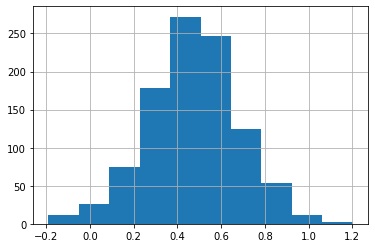

In [39]:
region_2_profits.hist()

In [40]:
lower = region_2_profits.quantile(0.025)
upper = region_2_profits.quantile(0.975)
print(f'95% доверительный интервал прибыли лежит в диапазоне от {round(lower, 3)} до {round(upper, 3)} млрд. рублей')

95% доверительный интервал прибыли лежит в диапазоне от 0.058 до 0.898 млрд. рублей


In [41]:
print(f"Вероятность получения отрицательной прибыли составляет {(region_2_profits < 0).mean():.1%}")
print(f"Среднее значение прибыли: {round(np.mean(region_2_profits), 3)} млрд. рублей")

Вероятность получения отрицательной прибыли составляет 2.0%
Среднее значение прибыли: 0.476 млрд. рублей


#### Регион 3

In [42]:
%%time

region_3_profits = bootstrap(predictions_valid_2)

CPU times: user 1.69 s, sys: 0 ns, total: 1.69 s
Wall time: 1.73 s


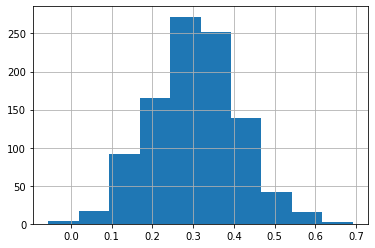

In [43]:
region_3_profits.hist()

In [44]:
lower = region_3_profits.quantile(0.025)
upper = region_3_profits.quantile(0.975)
print(f'95% доверительный интервал прибыли лежит в диапазоне от {round(lower, 3)} до {round(upper, 3)} млрд. рублей')

95% доверительный интервал прибыли лежит в диапазоне от 0.097 до 0.512 млрд. рублей


In [45]:
print(f"Вероятность получения отрицательной прибыли составляет {(region_3_profits < 0).mean():.1%}")
print(f"Среднее значение прибыли: {round(np.mean(region_3_profits), 3)} млрд. рублей")

Вероятность получения отрицательной прибыли составляет 0.3%
Среднее значение прибыли: 0.305 млрд. рублей


# Выводы

1. Для предсказания спроса для каждого из регионов была обучена модель, котороая впоследствии была использована для отбора 200 наиболее перспективных скважин
2. На основании данных о предсказании объемов залежей нефти, наиболее перспективным оказался Регион 1. В то время как регионы 2 и 3 показали сопоставимые цифры
3. Любой из регионов дает вероятность убытков менее 2.5%, что установлено в процессе бутстрепа. По этой причине выбор региона необходимо обосновать с позиции наибольшей средней прибыли. 
4. Лидером с точки зрения прибыли после бутстрепа стал регион 2 со значением в 0.476 миллиарда рублей

Таким образом - рекомендуем Регион 2. 